In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, tree
from shap import TreeExplainer, KernelExplainer
from imblearn.under_sampling import RandomUnderSampler
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
import pickle
from utils import *

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [19]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [20]:
# "class_weight": {0: 1, 1: 0.8} the model tends to predict more 1 than 0, so if you want to balance the prediction, you can use this parameter

params = {
    "random_state": 0,
    "max_depth": 14
}

In [21]:
dt = DecisionTreeClassifier(**params)
pv = DataPreprocessingAndValidation(ds, 7988, 5, DecisionTreeClassifier, params)

In [22]:
X_res, y_res = pv.get_undersampled_ds()
X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=y_res)

In [23]:
if False:
    cv = 10
    visualizer = LearningCurve(estimator=dt, cv=cv, scoring='f1', n_jobs=-1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="dt_data/learning_curve.png")


![Alt text](dt_data/learning_curve.png)

In [24]:
%time pv.cross_validation(ds[x_features], ds.Label, y_res)

Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
CPU times: user 14.9 s, sys: 75.9 ms, total: 15 s
Wall time: 15 s


(0.931048833214739, 0.0019756325483034462, 14.561039686203003)

In [19]:
%time dt.fit(X_train, y_train)

CPU times: user 2.46 s, sys: 4.44 ms, total: 2.47 s
Wall time: 2.47 s


DecisionTreeClassifier(max_depth=14, random_state=0)

In [14]:
%time y_predicted_train = dt.predict(X_train)
%time y_predicted_test = dt.predict(X_test)

CPU times: user 21.8 ms, sys: 3.94 ms, total: 25.7 ms
Wall time: 24.7 ms
CPU times: user 10.1 ms, sys: 0 ns, total: 10.1 ms
Wall time: 10.1 ms


In [15]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.926041,0.916438
1,PRECISION,0.931766,0.921057
2,RECALL,0.919408,0.910969
3,F1 SCORE,0.925546,0.915985
4,AUC,0.926041,0.916439


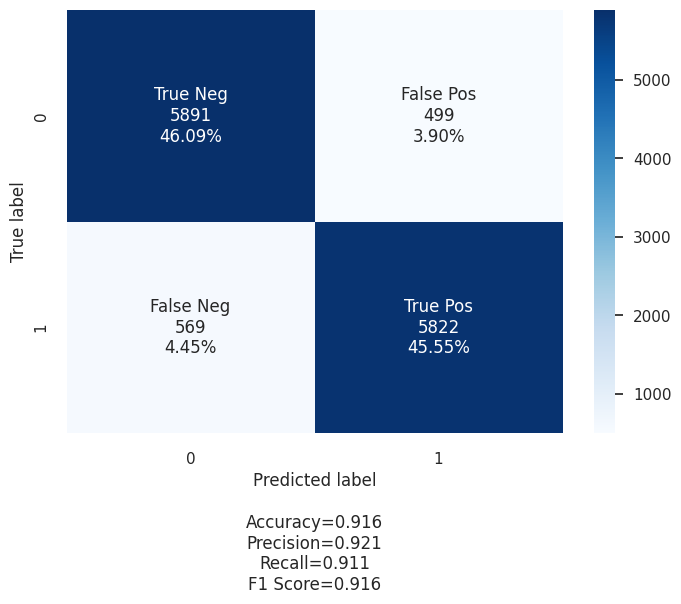

In [16]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [38]:
dot_data = tree.export_graphviz(dt, feature_names=x_features, out_file=None) 
graph = graphviz.Source(dot_data)
graph.render('tree/dt')

'tree/dt.pdf'

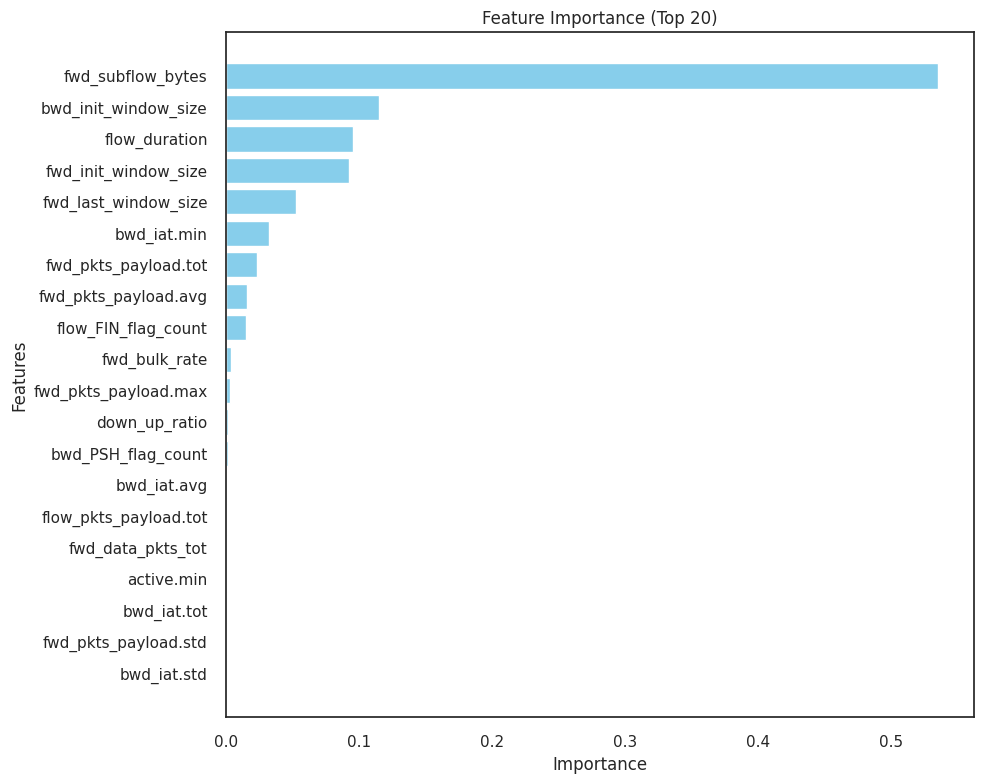

In [39]:
feature_importance = dt.feature_importances_
x_features_np = np.array(x_features)

# Sort indices based on feature importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = x_features_np[sorted_indices][:20][::-1]  # Select only the first 20 features
sorted_importance = feature_importance[sorted_indices][:20][::-1]  # Select importance values for the first 20 features

# Plotting
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.barh(range(len(sorted_importance)), sorted_importance, color='skyblue')
plt.yticks(range(len(sorted_importance)), sorted_features)  # Use yticks for feature names
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance (Top 20)')
plt.tight_layout()

# Show plot
plt.show()

In [40]:
%%time

explainer = fasttreeshap.TreeExplainer(dt, X_train, algorithm='auto', n_jobs=-1, feature_perturbation="interventional") 
sv = explainer(X_train)

exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1],
                  data=X_train, 
                  feature_names=x_features)

 96%|=================== | 97821/102246 [00:11<00:00]       

CPU times: user 10.8 s, sys: 60.1 ms, total: 10.9 s
Wall time: 10.9 s


In [25]:
sv[:,:,1]

.values =
array([[-0.13398401,  0.        ,  0.        , ...,  0.        ,
         0.00353273, -0.01320241],
       [ 0.21806918,  0.        ,  0.        , ...,  0.        ,
         0.03014328,  0.11209722],
       [-0.09644291,  0.        ,  0.        , ...,  0.        ,
         0.00109976, -0.09301947],
       ...,
       [-0.08383015,  0.        ,  0.        , ...,  0.        ,
         0.03308822, -0.20192768],
       [ 0.18409544,  0.        ,  0.        , ...,  0.        ,
         0.03209113,  0.12268572],
       [-0.24766335,  0.        ,  0.        , ...,  0.        ,
        -0.28995494, -0.00820229]])

.base_values =
array([0.53543695, 0.53543695, 0.53543695, ..., 0.53543695, 0.53543695,
       0.53543695])

.data =
array([[2.48260000e-02, 2.00000000e+00, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.52878300e+00, 3.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.80000000e-05, 

In [26]:
exp

.values =
array([[-0.13398401,  0.        ,  0.        , ...,  0.        ,
         0.00353273, -0.01320241],
       [ 0.21806918,  0.        ,  0.        , ...,  0.        ,
         0.03014328,  0.11209722],
       [-0.09644291,  0.        ,  0.        , ...,  0.        ,
         0.00109976, -0.09301947],
       ...,
       [-0.08383015,  0.        ,  0.        , ...,  0.        ,
         0.03308822, -0.20192768],
       [ 0.18409544,  0.        ,  0.        , ...,  0.        ,
         0.03209113,  0.12268572],
       [-0.24766335,  0.        ,  0.        , ...,  0.        ,
        -0.28995494, -0.00820229]])

.base_values =
array([0.53543695, 0.53543695, 0.53543695, ..., 0.53543695, 0.53543695,
       0.53543695])

.data =
       flow_duration  fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  \
12676       0.024826             2             2                  2   
24297       1.528783             3             0                  3   
4575        0.000088             1             

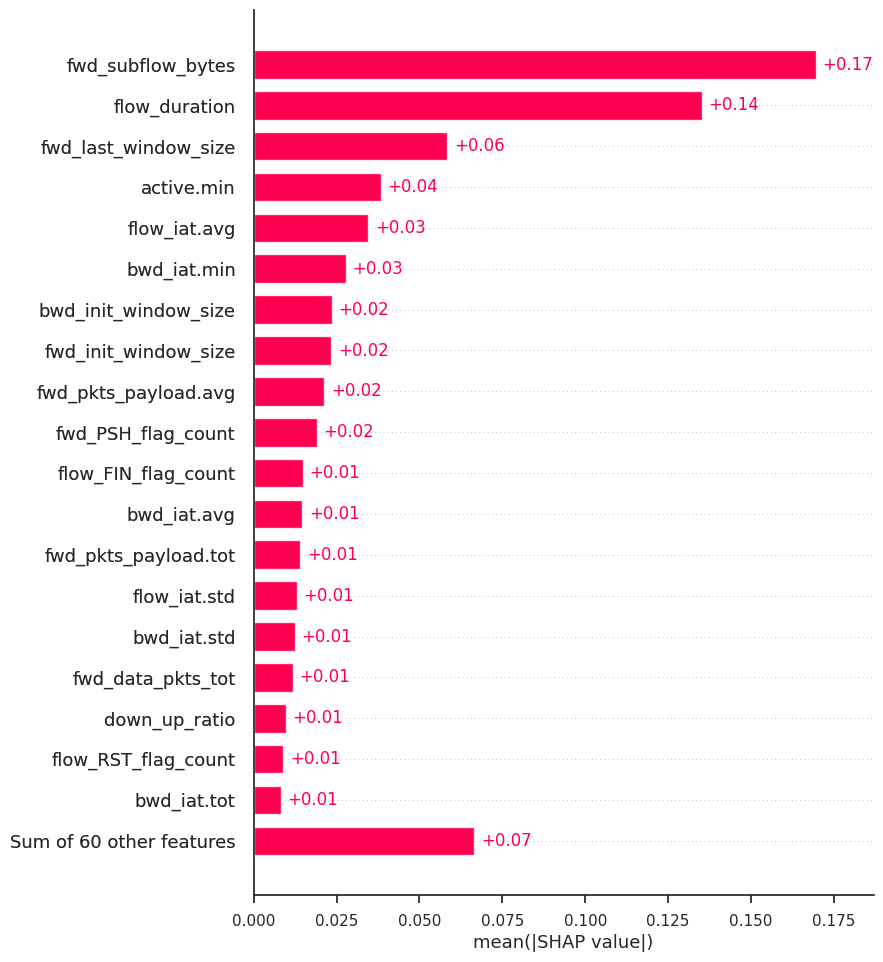

In [41]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

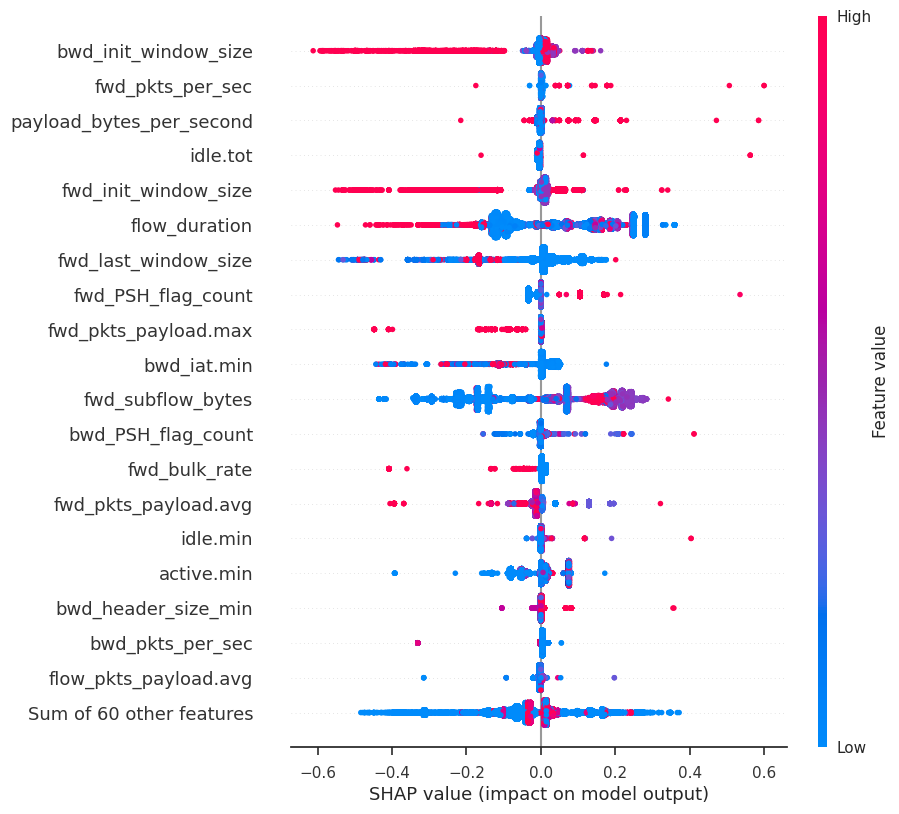

In [42]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

In [44]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
58,0.169600,fwd_subflow_bytes
0,0.135115,flow_duration
78,0.058351,fwd_last_window_size
66,0.038425,active.min
53,0.034618,flow_iat.avg
45,0.027751,bwd_iat.min
77,0.023643,bwd_init_window_size
76,0.023396,fwd_init_window_size
28,0.021310,fwd_pkts_payload.avg
18,0.019130,fwd_PSH_flag_count


In [45]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [46]:
%%time

if True:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('dt_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('dt_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

Running the cross validation
testing with 48 features
Running the cross validation
testing with 47 features
Running the cross validation
testing with 46 features
Running the cross validation
testing with 45 features
Running the cross validation
testing with 44 features
Running the cross validation
testing with 43 features
Running the cross validation
testing with 42 features
Running the cross validation
testing with 41 features
Running the cross validation
testing with 40 features
Running the cross validation
testing with 39 features
Running the cross validation
testing with 38 features
Running the cross validation
testing with 37 features
Running the cross validation
testing with 36 features
Running the cross validation
testing with 35 features
Running the cross validation
testing with 34 features
Running the cross validation
testing with 33 features
Running the cross validation


KeyboardInterrupt: 

<Axes: xlabel='n_features', ylabel='cv_time'>

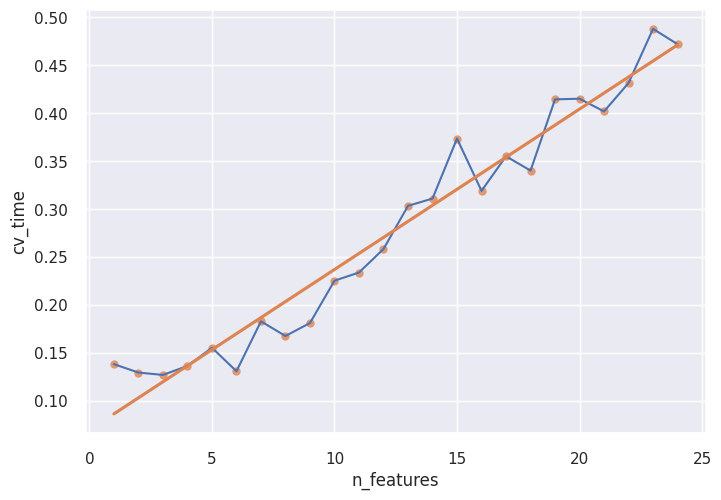

In [32]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

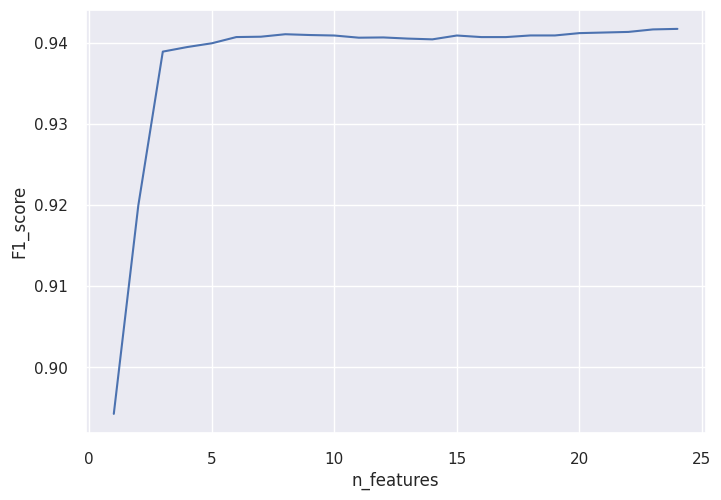

In [33]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

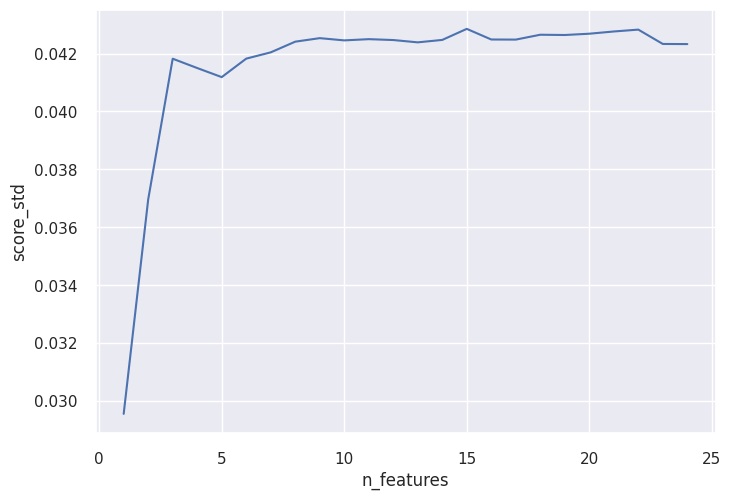

In [34]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [35]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
0,0.941684,0.042326,24,0.472029
1,0.941617,0.042330,23,0.488026
2,0.941309,0.042825,22,0.431597
3,0.941235,0.042761,21,0.401933
4,0.941160,0.042684,20,0.415183
5,0.940873,0.042639,19,0.414499
6,0.940873,0.042649,18,0.340218
7,0.940672,0.042481,17,0.355116
8,0.940672,0.042484,16,0.319056
9,0.940865,0.042851,15,0.373625


In [47]:
%%time

if True:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('dt_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('dt_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

traing for  XMRIGCC CryptoMiner
training with 48 features
Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
training with 47 features


KeyboardInterrupt: 

In [50]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [51]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
97,0.691450,0.595608,0.824051,0.939366,0.038852,3,Bruteforce-XML,0.021292,0.001351,1
96,0.691572,0.595608,0.824398,0.938301,0.038155,4,Bruteforce-XML,0.019706,0.001144,1
84,0.651841,0.545288,0.810150,0.939028,0.039948,16,Bruteforce-XML,0.222330,0.006586,1
83,0.651841,0.545288,0.810150,0.938998,0.039878,17,Bruteforce-XML,0.085760,0.002126,1
98,0.573278,0.459286,0.762532,0.922266,0.035625,2,Bruteforce-XML,0.021157,0.001334,1
...,...,...,...,...,...,...,...,...,...,...
17,0.000545,0.000305,0.002564,0.944900,0.047293,8,XMRIGCC CryptoMiner,0.031602,0.001372,1
35,0.000589,0.000305,0.008475,0.980667,0.002415,15,Probing,0.067877,0.001633,1
2,0.000546,0.000305,0.002597,0.945391,0.046641,23,XMRIGCC CryptoMiner,0.132513,0.001990,1
37,0.000589,0.000305,0.008403,0.980670,0.002421,13,Probing,0.068318,0.001616,1


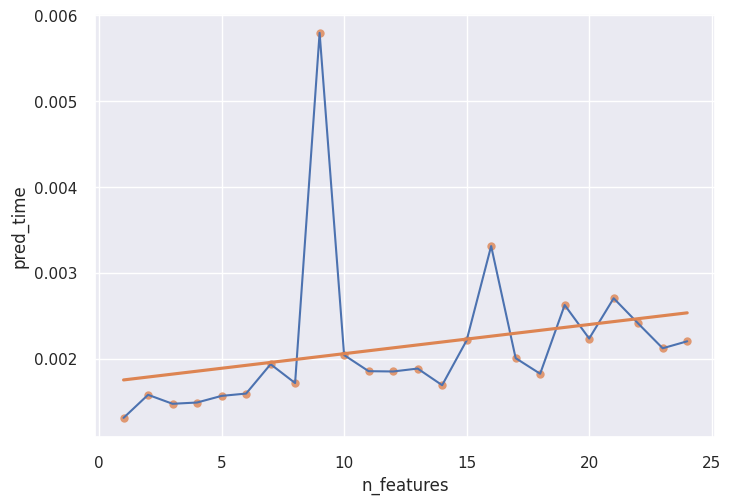

In [52]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

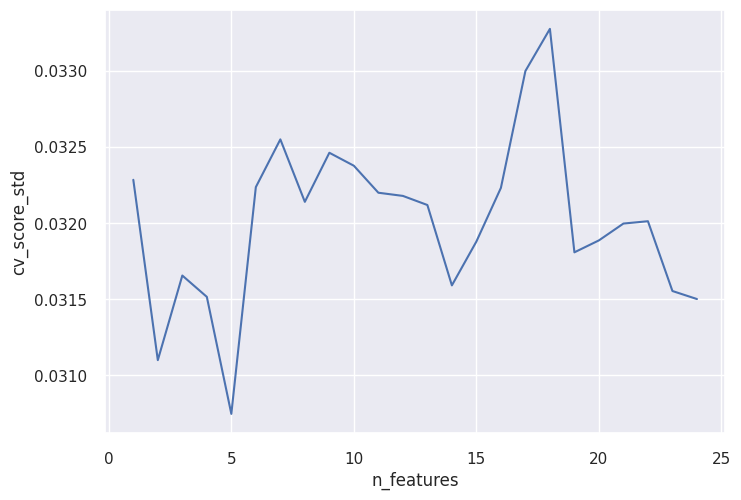

In [53]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [54]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
3,0.294043,0.238411,0.393553,0.951804,0.031656,0.024066,0.001473,0.50
4,0.291683,0.236048,0.392621,0.951722,0.031516,0.034070,0.001488,0.50
17,0.238945,0.186185,0.367551,0.952005,0.032999,0.081383,0.002005,1.00
16,0.165418,0.137694,0.214306,0.953076,0.032232,0.131806,0.003311,0.75
2,0.145498,0.116041,0.200811,0.938988,0.031101,0.024604,0.001578,0.50
23,0.078258,0.051235,0.169404,0.953811,0.031555,0.121905,0.002120,0.75
21,0.076170,0.050091,0.159301,0.953525,0.031998,0.119747,0.002703,0.50
18,0.076071,0.050015,0.159212,0.952003,0.033276,0.080444,0.001823,0.50
20,0.076011,0.049939,0.159682,0.953511,0.031887,0.150924,0.002234,0.75


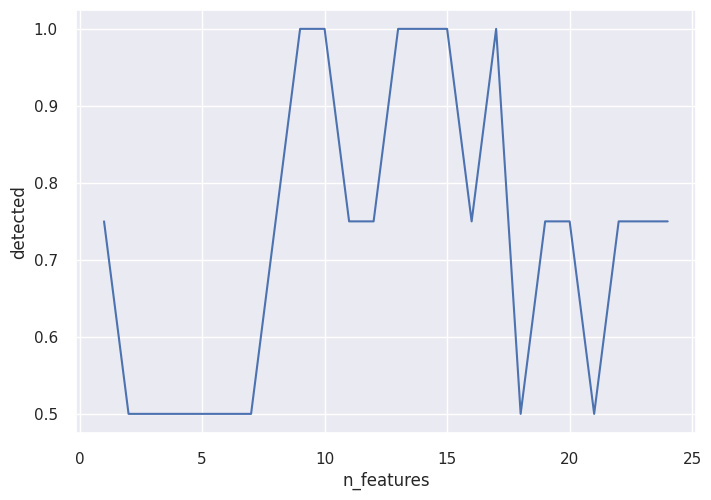

In [55]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

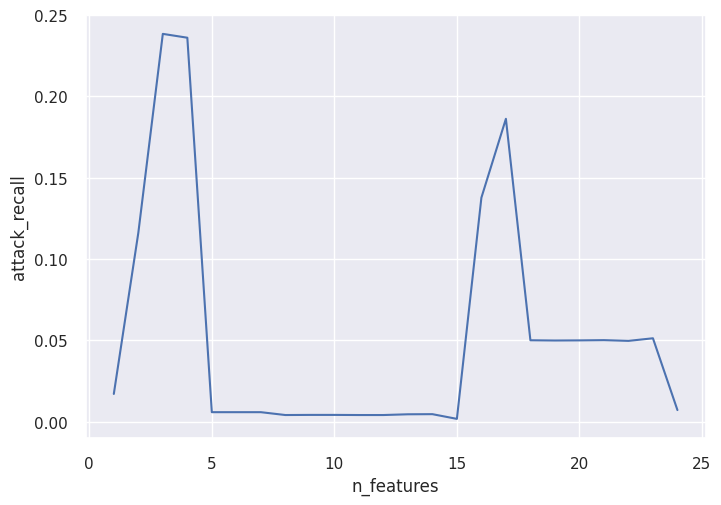

In [56]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [57]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
3,0.294043,0.238411,0.393553,0.951804,0.031656,0.024066,0.001473
4,0.291683,0.236048,0.392621,0.951722,0.031516,0.034070,0.001488
17,0.238945,0.186185,0.367551,0.952005,0.032999,0.081383,0.002005
16,0.165418,0.137694,0.214306,0.953076,0.032232,0.131806,0.003311
2,0.145498,0.116041,0.200811,0.938988,0.031101,0.024604,0.001578
23,0.078258,0.051235,0.169404,0.953811,0.031555,0.121905,0.002120
21,0.076170,0.050091,0.159301,0.953525,0.031998,0.119747,0.002703
18,0.076071,0.050015,0.159212,0.952003,0.033276,0.080444,0.001823
20,0.076011,0.049939,0.159682,0.953511,0.031887,0.150924,0.002234


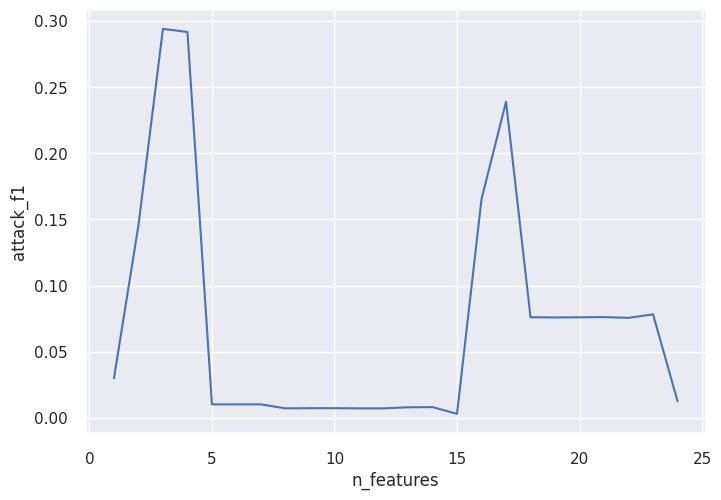

In [58]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [60]:
zero_day_feature_reduction_scores.query('n_features == 3')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
22,0.000000,0.000000,0.000000,0.943387,0.045712,3,XMRIGCC CryptoMiner,0.023590,0.001266,0
47,0.000000,0.000000,0.000000,0.979869,0.002136,3,Probing,0.033463,0.002074,0
72,0.484723,0.358036,0.750160,0.944593,0.039925,3,Bruteforce,0.017917,0.001200,1
97,0.691450,0.595608,0.824051,0.939366,0.038852,3,Bruteforce-XML,0.021292,0.001351,1
